# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import annotations
from sklearn.base import BaseEstimator
from typing import Iterable, List, Tuple
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [ ]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None

    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        _, d = X.shape
        if self.w0 is None:
            self.w = np.zeros(d)
        else:
            self.w = self.w0
        
        self.loss_history = []
        
        for i in range(self.max_iter):
            gradient = self.calc_gradient(X, y)
            self.w -= self.eta * gradient
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)
            
            if np.linalg.norm(gradient) < self.tolerance:
                break
        return self

    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
          
        z = np.dot(X, self.w)
        prob = 1 / (1 + np.exp(-z))
        return np.column_stack((1 - prob, prob))

    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
          
        prob = self.predict_proba(X)[:, 1]
        return (prob >= 0.5).astype(int)


    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        m = len(y)
        y_pred = self.predict_proba(X)[:, 1]
        gradient = - (1/m) * np.dot(X.T, (y - y_pred))
        
        if self.gd_type == 'stochastic':
            idx = np.random.randint(m)
            gradient = - (y[idx] - y_pred[idx]) * X[idx]
        
        return gradient

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        y_pred = self.predict_proba(X)[:, 1]
        loss = - np.mean(y * np.log(y_pred + 1e-15) + (1 - y) * np.log(1 - y_pred + 1e-15))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [ ]:
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

In [10]:
model = MyLogisticRegression(
    gd_type='full', tolerance=1e-6, max_iter=10000, eta=0.01
)
model.fit(X_train, y_train)

MyLogisticRegression(gd_type='full', max_iter=10000)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

ROC-AUC: 0.8586
PR-AUC: 0.8202


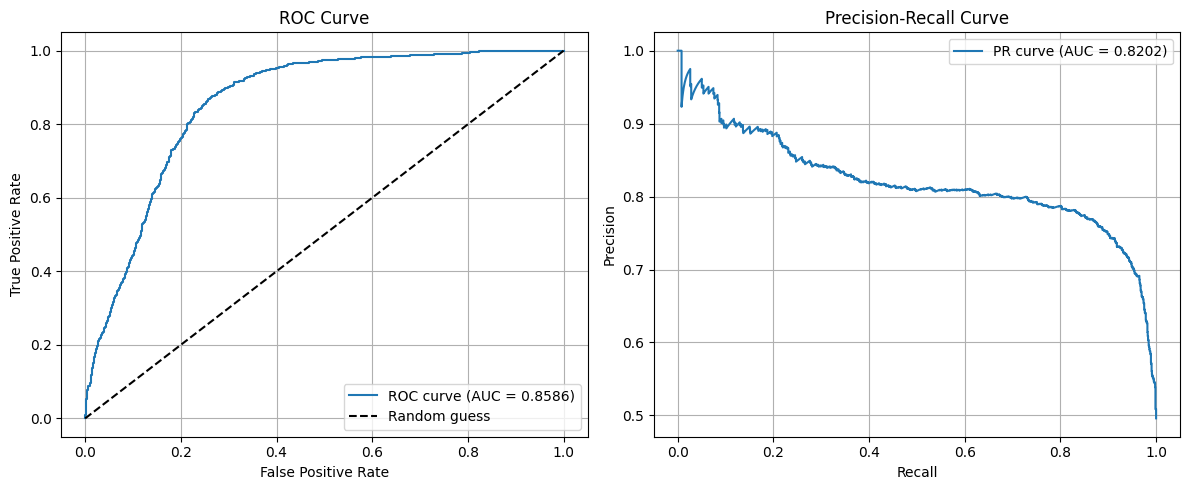

In [ ]:
y_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=999)
roc_auc_scores = []
pr_auc_scores = []

for train_idx, test_idx in kf.split(X):
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train_fold, y_test_fold = y[train_idx], y[test_idx]
    model_cv = MyLogisticRegression(
        gd_type='full', tolerance=1e-6, max_iter=10000, eta=0.01
    )
    model_cv.fit(X_train_fold, y_train_fold)
    y_proba_fold = model_cv.predict_proba(X_test_fold)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_test_fold, y_proba_fold))
    pr_auc_scores.append(average_precision_score(y_test_fold, y_proba_fold))

print(f"ROC-AUC: mean = {np.mean(roc_auc_scores):.4f}, std = {np.std(roc_auc_scores):.4f}")
print(f"PR-AUC:  mean = {np.mean(pr_auc_scores):.4f}, std = {np.std(pr_auc_scores):.4f}")

ROC-AUC: mean = 0.8608, std = 0.0042
PR-AUC:  mean = 0.8322, std = 0.0077


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [ ]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [ ]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
#data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [17]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [18]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [20]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [ ]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    y = R[:, -1]  
    if len(y) == 0:
        return 0  
    return np.var(y)

def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    feature_index = X_train.columns.get_loc(feature)
    left = R_m[R_m[:, feature_index] <= t]
    right = R_m[R_m[:, feature_index] > t]
    return left, right

def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    R_l, R_r = split_node(R_m, feature, t)
    n = len(R_m)
    return (len(R_l) / n) * H(R_l) + (len(R_r) / n) * H(R_r)

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

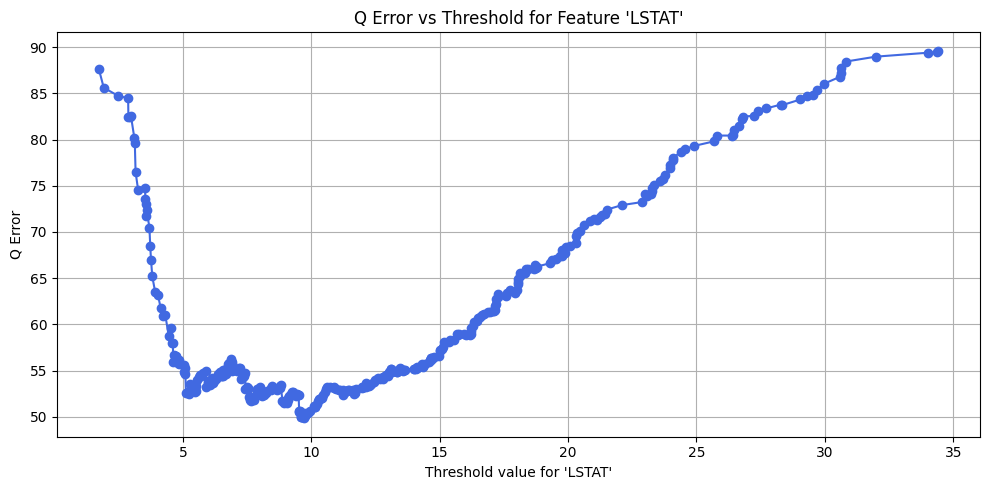

In [ ]:
feature = 'LSTAT'
R_m = X_train.values
feature_index = X_train.columns.get_loc(feature)
thresholds = np.unique(R_m[:, feature_index])
errors = [q_error(R_m, feature, t) for t in thresholds]

plt.figure(figsize=(10, 5))
plt.plot(thresholds, errors, marker='o', linestyle='-', color='royalblue')
plt.title(f"Q Error vs Threshold for Feature '{feature}'")
plt.xlabel(f"Threshold value for '{feature}'")
plt.ylabel("Q Error")
plt.grid(True)
plt.tight_layout()
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [23]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    feature_index = X_train.columns.get_loc(feature)
    thresholds = np.unique(R_m[:, feature_index])

    q_values = []
    for t in thresholds:
        q = q_error(R_m, feature, t)
        q_values.append(q)
    
    min_index = int(np.argmin(q_values))
    optimal_t = thresholds[min_index]

    return optimal_t, q_values

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [25]:
def find_best_split(R_m: np.array, features: List[str]) -> Tuple[str, float, float, List[float]]:
    """
    Находит лучший признак и порог для разбиения множества R_m.
    
    Возвращает:
    - название лучшего признака,
    - лучший порог,
    - минимальное значение ошибки Q,
    - список Q-ошибок для этого признака (для построения графика).
    """
    best_feature = None
    best_t = None
    best_q = float('inf')
    best_q_vals = []

    for feature in features:
        t_opt, q_vals = get_optimal_split(R_m, feature)
        q_min = min(q_vals)
        if q_min < best_q:
            best_q = q_min
            best_feature = feature
            best_t = t_opt
            best_q_vals = q_vals

    return best_feature, best_t, best_q, best_q_vals

 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

In [ ]:
R_m = X_train.values
features = X_train.columns.drop('target').tolist()
best_feature, best_t, best_q, best_q_vals = find_best_split(R_m, features)

print(f"Лучший признак: {best_feature}")
print(f"Оптимальный порог: {best_t:.4f}")
print(f"Минимальное значение Q: {best_q:.4f}")

Лучший признак: RM
Оптимальный порог: 6.8330
Минимальное значение Q: 49.3809


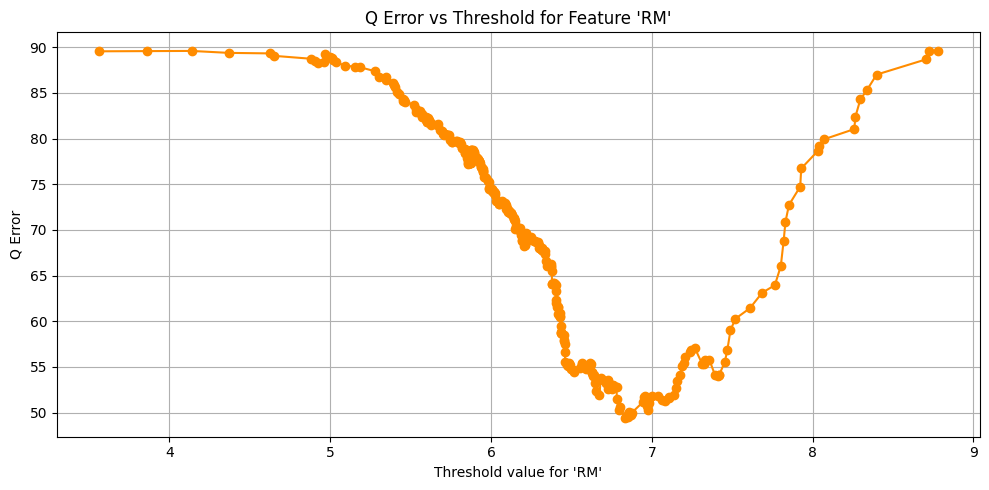

In [ ]:
feature_index = X_train.columns.get_loc(best_feature)
thresholds = np.unique(R_m[:, feature_index])

plt.figure(figsize=(10, 5))
plt.plot(thresholds, best_q_vals, color='darkorange', marker='o')
plt.title(f"Q Error vs Threshold for Feature '{best_feature}'")
plt.xlabel(f"Threshold value for '{best_feature}'")
plt.ylabel("Q Error")
plt.grid(True)
plt.tight_layout()
plt.show()

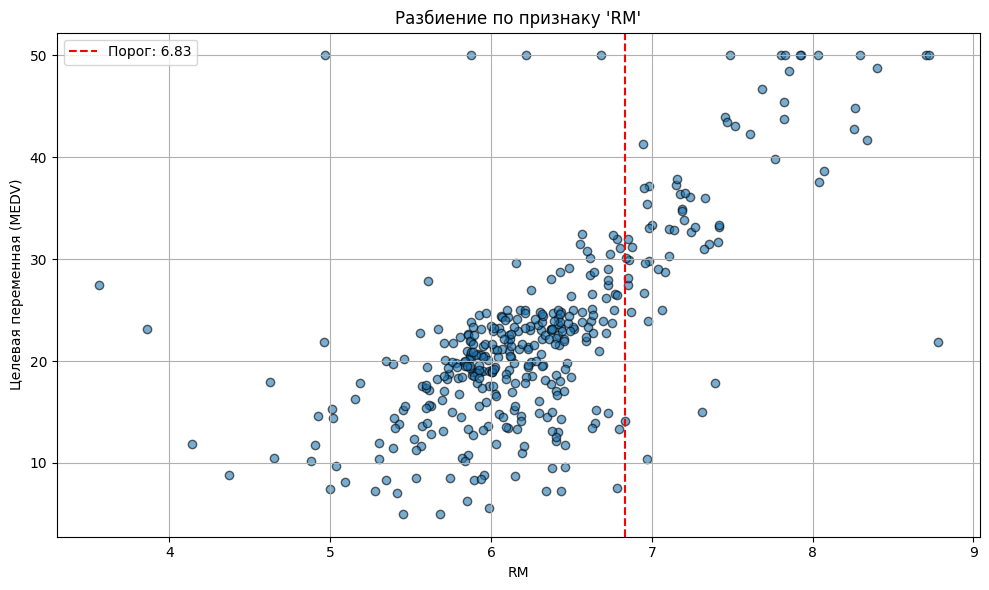

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train[best_feature], X_train['target'], alpha=0.6, edgecolor='k')
plt.axvline(x=best_t, color='red', linestyle='--', label=f"Порог: {best_t:.2f}")
plt.title(f"Разбиение по признаку '{best_feature}'")
plt.xlabel(best_feature)
plt.ylabel("Целевая переменная (MEDV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()